# 05 - Active City Index

**Ziel:** Fuehrt alle Teilindikatoren zusammen und berechnet den Active City Index.

**Inputs:** interim + processed Indikator-Dateien aus 01-04

**Outputs:** data/processed/muc_active_city_index.(csv|geojson|gpkg)

**Ausfuehrung:** Von oben nach unten ausfuehren (Restart & Run All). Dieses Notebook ist Teil der Pipeline 00 -> 05.


In [1]:
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
INTERIM_DIR = DATA_DIR / "interim"
PROCESSED_DIR = DATA_DIR / "processed"

BASE_DIR, INTERIM_DIR, PROCESSED_DIR


(PosixPath('..'), PosixPath('../data/interim'), PosixPath('../data/processed'))

In [2]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import numpy as np

place_name = "München, Deutschland"
public_access_values = {"yes", "public", "permissive", "destination"}

def _safe_series(df, col, default=""):
    if col in df.columns:
        return df[col].astype(str).str.lower().fillna(default)
    return pd.Series([default] * len(df), index=df.index)

def _minmax(series):
    s = pd.to_numeric(series, errors="coerce").fillna(0.0)
    den = s.max() - s.min()
    if den == 0:
        return pd.Series(0.0, index=s.index)
    return (s - s.min()) / den

## Daten Laden

Die vorbereiteten Basis- und Themenlayer (Parks, Sport, Mobility) werden eingelesen und kurz geprueft.


## Datenintegration und Indexkonstruktion

Die Teil-Datensaetze werden zu einem gemeinsamen Analyse-GeoDataFrame (`gdf_active`) zusammengefuehrt.


In [3]:
# Basis: Bezirke + Bevölkerung + Fläche
gdf_base = gpd.read_file(INTERIM_DIR / "muc_bezirke_bev_clean.geojson")

# Parks
gdf_parks = gpd.read_file(PROCESSED_DIR / "muc_bezirke_parks.geojson")[[
    "bez_nr",
    "parks_count",
    "parks_area_ha",
    "parks_pro_1000_einw",
    "parks_area_anteil_prozent"
]]

# Sport
gdf_sport = gpd.read_file(PROCESSED_DIR / "muc_bezirke_sport.geojson")[[
    "bez_nr",
    "sports_count",
    "sports_area_ha",
    "sports_pro_1000_einw",
    "sports_area_anteil_prozent"
]]

# Mobility (ÖPNV + Radwege)
gdf_mob = gpd.read_file(PROCESSED_DIR / "muc_bezirke_mobility.geojson")[[
    "bez_nr",
    "stops_count",
    "stops_pro_1000_einw",
    "radweg_length_m",
    "radweg_km",
    "radweg_km_pro_km2"
]]


In [4]:
gdf_base.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   bez_nr           25 non-null     int32   
 1   name             25 non-null     object  
 2   stadtbezirk      25 non-null     object  
 3   einwohner        25 non-null     int32   
 4   flaeche_ha       25 non-null     float64 
 5   einwohnerdichte  25 non-null     float64 
 6   geometry         25 non-null     geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 1.3+ KB


In [5]:
gdf_parks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bez_nr                     25 non-null     int32  
 1   parks_count                25 non-null     int32  
 2   parks_area_ha              25 non-null     float64
 3   parks_pro_1000_einw        25 non-null     float64
 4   parks_area_anteil_prozent  25 non-null     float64
dtypes: float64(3), int32(2)
memory usage: 932.0 bytes


In [6]:
gdf_sport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bez_nr                      25 non-null     int32  
 1   sports_count                25 non-null     int32  
 2   sports_area_ha              25 non-null     float64
 3   sports_pro_1000_einw        25 non-null     float64
 4   sports_area_anteil_prozent  25 non-null     float64
dtypes: float64(3), int32(2)
memory usage: 932.0 bytes


In [7]:
gdf_mob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bez_nr               25 non-null     int32  
 1   stops_count          25 non-null     int32  
 2   stops_pro_1000_einw  25 non-null     float64
 3   radweg_length_m      25 non-null     float64
 4   radweg_km            25 non-null     float64
 5   radweg_km_pro_km2    25 non-null     float64
dtypes: float64(4), int32(2)
memory usage: 1.1 KB


### Zusammenfuehrung zum Analyse-Datensatz `gdf_active`


In [8]:
gdf_active = (
    gdf_base
    .merge(gdf_parks, on="bez_nr", how="left")
    .merge(gdf_sport, on="bez_nr", how="left")
    .merge(gdf_mob,   on="bez_nr", how="left")
)

kennzahl_spalten = [
    "parks_count", "parks_area_ha", "parks_pro_1000_einw", "parks_area_anteil_prozent",
    "sports_count", "sports_area_ha", "sports_pro_1000_einw", "sports_area_anteil_prozent",
    "stops_count", "stops_pro_1000_einw",
    "radweg_length_m", "radweg_km", "radweg_km_pro_km2"
]

for col in kennzahl_spalten:
    gdf_active[col] = gdf_active[col].fillna(0)

gdf_active[[
    "bez_nr", "name", "einwohner",
    "parks_pro_1000_einw",
    "sports_pro_1000_einw",
    "stops_pro_1000_einw",
    "radweg_km_pro_km2"
]].head()

,bez_nr,name,einwohner,parks_pro_1000_einw,sports_pro_1000_einw,stops_pro_1000_einw,radweg_km_pro_km2
0,1,Altstadt-Lehel,20876,1.293351,0.910136,8.478636,7.950604
1,2,Ludwigsvorstadt-Isarvorstadt,50081,0.419321,0.738803,6.629261,7.694313
2,3,Maxvorstadt,52434,0.667506,0.858222,3.642675,6.513534
3,4,Schwabing-West,68610,0.335228,0.816208,2.565224,8.608748
4,5,Au-Haidhausen,63972,0.562746,1.031701,3.923592,7.219785


### Konfiguration der Index-Dimensionen und Indikatoren


In [9]:
# Grün & Erholung
GREEN_INDICATORS = [
    "parks_pro_1000_einw",
    "parks_area_anteil_prozent",
]

# Sportinfrastruktur
SPORT_INDICATORS = [
    "sports_pro_1000_einw",
    "sports_area_anteil_prozent",
]

# Mobilität (ÖPNV + Radwege)
MOBILITY_INDICATORS = [
    "stops_pro_1000_einw",
    "radweg_km_pro_km2",
]

# Alle verwendeten Indikatoren in einer Liste sammeln (für Normalisierung)
ALL_INDICATORS = list(set(
    GREEN_INDICATORS + SPORT_INDICATORS + MOBILITY_INDICATORS
))

ALL_INDICATORS

['radweg_km_pro_km2',
 'parks_area_anteil_prozent',
 'stops_pro_1000_einw',
 'parks_pro_1000_einw',
 'sports_area_anteil_prozent',
 'sports_pro_1000_einw']

### Index-Engine (Normalisierung und Gewichtung)


In [10]:
# Normalisierungsfunktion
def normalize_series(x, method="minmax"):
    if method == "minmax":
        return (x - x.min()) / (x.max() - x.min())
    elif method == "zscore":
        return (x - x.mean()) / x.std()
    else:
        raise ValueError("Unknown method")

In [11]:
# Funktion zur Berechnung des Active City Index
def compute_active_city_index(
    gdf,
    green_ind,
    sport_ind,
    mob_ind,
    weights=None,
    norm_method="minmax"
):
    if weights is None:
        weights = {"green": 1/3, "sport": 1/3, "mob": 1/3}

    all_inds = list(set(green_ind + sport_ind + mob_ind))

    # 1) Normalisierung
    for col in all_inds:
        col_norm = col + "_norm"
        gdf[col_norm] = normalize_series(gdf[col], method=norm_method)

    # 2) Teilindizes
    gdf["index_gruen"] = gdf[[c + "_norm" for c in green_ind]].mean(axis=1)
    gdf["index_sport"] = gdf[[c + "_norm" for c in sport_ind]].mean(axis=1)
    gdf["index_mobil"] = gdf[[c + "_norm" for c in mob_ind]].mean(axis=1)

    # 3) Gesamtindex
    gdf["active_city_index"] = (
        weights["green"] * gdf["index_gruen"] +
        weights["sport"] * gdf["index_sport"] +
        weights["mob"]   * gdf["index_mobil"]
    )
    return gdf

### Baseline-Index mit gleichen Gewichten


In [12]:
active_index = compute_active_city_index(
    gdf_active,
    GREEN_INDICATORS,
    SPORT_INDICATORS,
    MOBILITY_INDICATORS,
    weights={"green": 1/3, "sport": 1/3, "mob": 1/3}
)

In [13]:
cols = [
    "bez_nr",
    "name",
    "active_city_index",
    "index_gruen",
    "index_sport",
    "index_mobil"
]

active_index[cols] \
    .sort_values("active_city_index", ascending=False) \
    .reset_index(drop=True) \
    .head(25)   


,bez_nr,name,active_city_index,index_gruen,index_sport,index_mobil
0,1,Altstadt-Lehel,0.653878,1.000000,0.147427,0.814208
1,11,Milbertshofen-Am Hart,0.537791,0.147440,0.937321,0.528612
2,15,Trudering-Riem,0.532843,0.402031,0.767300,0.429199
3,6,Sendling,0.458882,0.215271,0.645821,0.515555
4,12,Schwabing-Freimann,0.450114,0.198173,0.751703,0.400466
5,18,Untergiesing-Harlaching,0.448552,0.291213,0.630459,0.423984
6,10,Moosach,0.429969,0.262117,0.564410,0.463379
7,7,Sendling-Westpark,0.427610,0.179895,0.641804,0.461129
8,16,Ramersdorf-Perlach,0.412415,0.094927,0.642858,0.499459
9,21,Pasing-Obermenzing,0.386224,0.384592,0.406110,0.367970


In [14]:
assert active_index["active_city_index"].between(0, 1).all()
assert active_index["index_gruen"].between(0, 1).all()
assert len(active_index) == 25  # 25 Stadtbezirke

## Auswertung und Visualisierung


### Erste Auswertung des Active City Index

Zur Einordnung des Index betrachten wir:

- die Verteilung der Indexwerte über alle Stadtbezirke (Histogramm)
- ein Ranking der Bezirke (Top/Bottom-Bezirke)

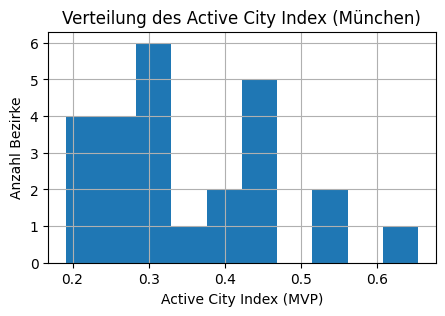

In [15]:
plt.figure(figsize=(5, 3))
active_index["active_city_index"].hist(bins=10)
plt.xlabel("Active City Index (MVP)")
plt.ylabel("Anzahl Bezirke")
plt.title("Verteilung des Active City Index (München)")
plt.show()

In [16]:

ranking = (
    active_index[cols]
    .sort_values("active_city_index", ascending=False)
    .reset_index(drop=True)
)

In [17]:
top5 = ranking.head(5)
bottom5 = ranking.tail(5)

display(top5)
display(bottom5)

,bez_nr,name,active_city_index,index_gruen,index_sport,index_mobil
0,1,Altstadt-Lehel,0.653878,1.000000,0.147427,0.814208
1,11,Milbertshofen-Am Hart,0.537791,0.147440,0.937321,0.528612
2,15,Trudering-Riem,0.532843,0.402031,0.767300,0.429199
3,6,Sendling,0.458882,0.215271,0.645821,0.515555
4,12,Schwabing-Freimann,0.450114,0.198173,0.751703,0.400466


,bez_nr,name,active_city_index,index_gruen,index_sport,index_mobil
20,8,Schwanthalerhöhe,0.240362,0.022620,0.123763,0.574701
21,4,Schwabing-West,0.226031,0.148498,0.151581,0.378015
22,24,Feldmoching-Hasenbergl,0.219143,0.046405,0.486667,0.124356
23,20,Hadern,0.213389,0.113567,0.267076,0.259525
24,25,Laim,0.191090,0.208803,0.080665,0.283801


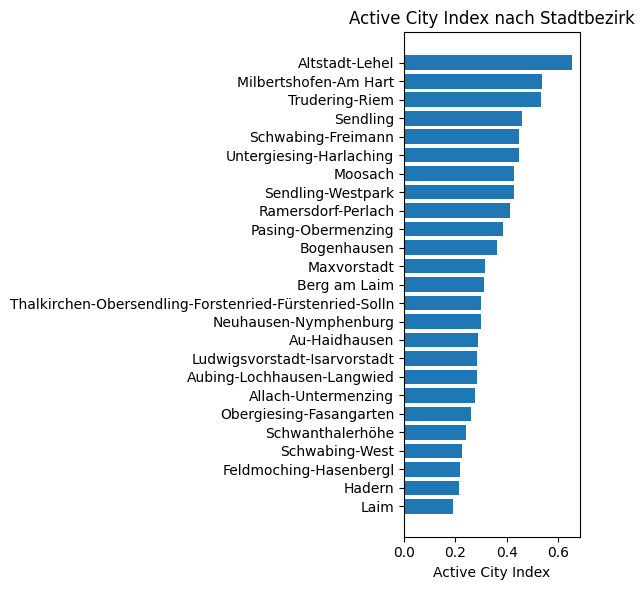

In [18]:
ordered = active_index[["name", "active_city_index"]].sort_values(
    "active_city_index", ascending=True
)

plt.figure(figsize=(6, 6))
plt.barh(ordered["name"], ordered["active_city_index"])
plt.xlabel("Active City Index")
plt.title("Active City Index nach Stadtbezirk")
plt.tight_layout()
plt.show()

### Räumliche Verteilung des Active City Index

Der Index wird als Choroplethenkarte auf Bezirksebene visualisiert, um räumliche Muster zu erkennen.

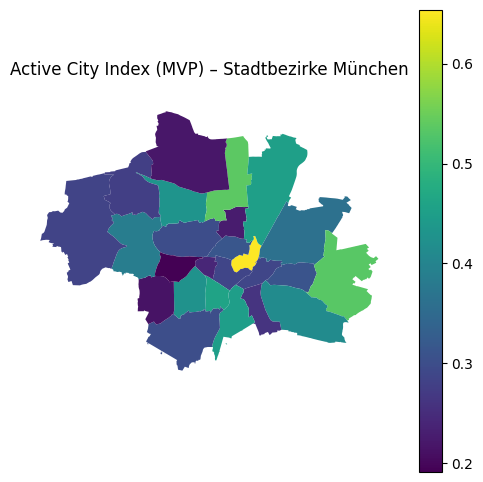

In [19]:
ax = active_index.plot(
    column="active_city_index",
    legend=True,
    figsize=(6, 6)
)
plt.title("Active City Index (MVP) – Stadtbezirke München")
plt.axis("off")
plt.show()

### Scatterplots und Korrelationen


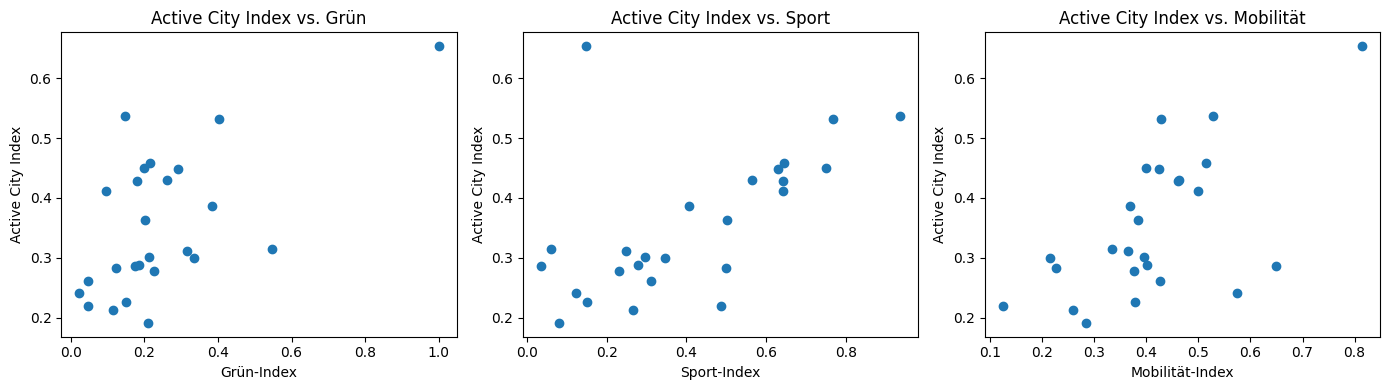

In [20]:
dims = ["index_gruen", "index_sport", "index_mobil"]
titles = ["Grün", "Sport", "Mobilität"]

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for col, title, ax in zip(dims, titles, axes):
    ax.scatter(active_index[col], active_index["active_city_index"])
    ax.set_xlabel(f"{title}-Index")
    ax.set_ylabel("Active City Index")
    ax.set_title(f"Active City Index vs. {title}")

plt.tight_layout()
plt.show()

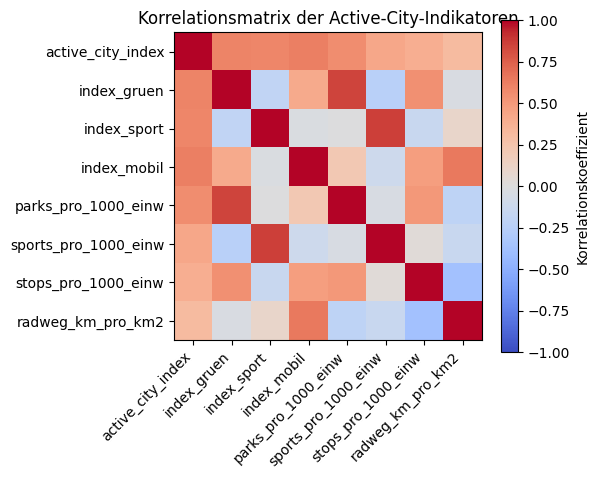

In [21]:
corr_cols = [
    "active_city_index",
    "index_gruen",
    "index_sport",
    "index_mobil",
    "parks_pro_1000_einw",
    "sports_pro_1000_einw",
    "stops_pro_1000_einw",
    "radweg_km_pro_km2",
]

corr = active_index[corr_cols].corr()

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)

ax.set_xticks(np.arange(len(corr_cols)))
ax.set_yticks(np.arange(len(corr_cols)))
ax.set_xticklabels(corr_cols, rotation=45, ha="right")
ax.set_yticklabels(corr_cols)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Korrelationskoeffizient")

ax.set_title("Korrelationsmatrix der Active-City-Indikatoren")
plt.tight_layout()
plt.show()

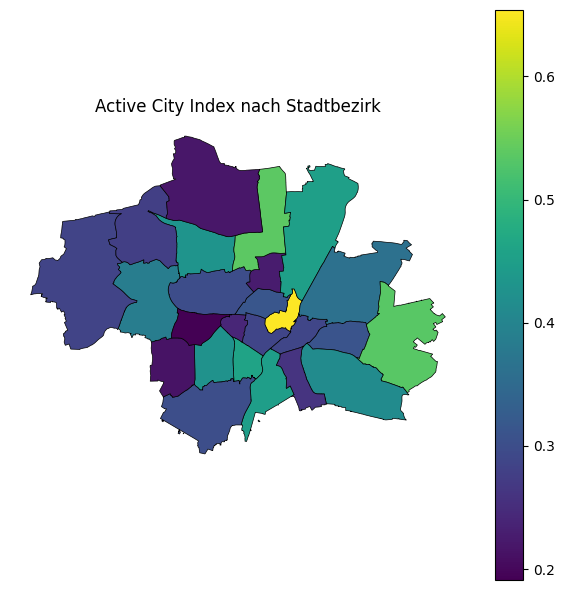

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
active_index.plot(
    column="active_city_index",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.5,
    ax=ax
)
ax.set_axis_off()
ax.set_title("Active City Index nach Stadtbezirk")
plt.tight_layout()
plt.show()

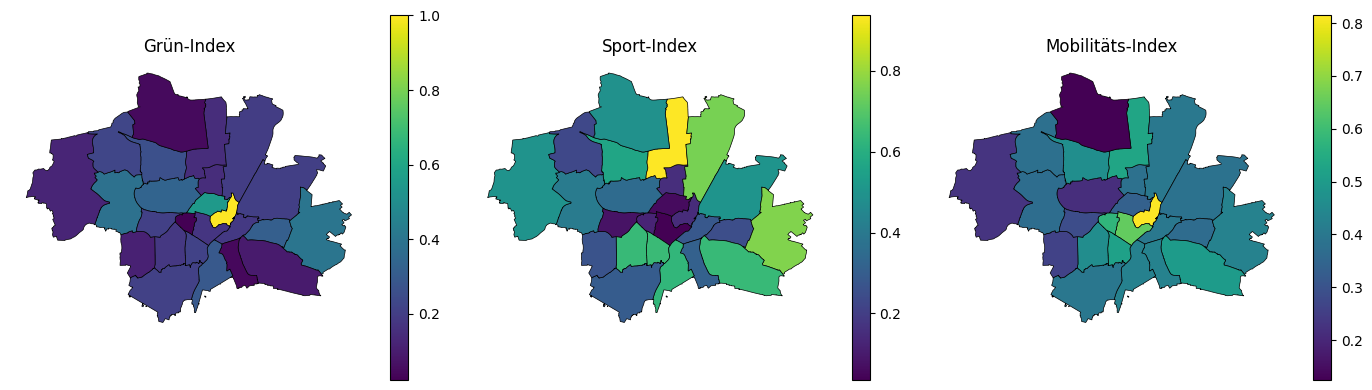

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for col, title, ax in zip(
    ["index_gruen", "index_sport", "index_mobil"],
    ["Grün-Index", "Sport-Index", "Mobilitäts-Index"],
    axes
):
    active_index.plot(
        column=col,
        cmap="viridis",
        legend=True,
        edgecolor="black",
        linewidth=0.5,
        ax=ax
    )
    ax.set_axis_off()
    ax.set_title(title)

plt.tight_layout()
plt.show()

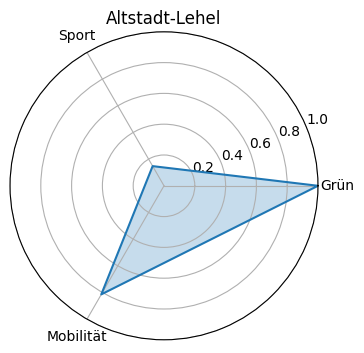

In [24]:
# Spinnenrad-Plot für einen Bezirk
import numpy as np

def plot_bezirk_profile(row):
    labels = ["Grün", "Sport", "Mobilität"]
    values = [
        row["index_gruen"],
        row["index_sport"],
        row["index_mobil"]
    ]
    values += values[:1]  # Radar close

    angles = np.linspace(0, 2*np.pi, len(labels) + 1)

    fig, ax = plt.subplots(subplot_kw={"polar": True}, figsize=(4, 4))
    ax.plot(angles, values)
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1)
    ax.set_title(row["name"])
    plt.show()

# Beispiel für einen Bezirk:
plot_bezirk_profile(active_index.iloc[0])

## Robustheit: Gewichtungsszenarien

Vergleich der Rangfolgen unter alternativen Gewichtungen.


In [25]:
if "aci_equal" not in active_index.columns:
    active_index["aci_equal"] = active_index["active_city_index"]

if "aci_green_focus" not in active_index.columns:
    active_index["aci_green_focus"] = (
        0.5 * active_index["index_gruen"] +
        0.25 * active_index["index_sport"] +
        0.25 * active_index["index_mobil"]
    )

if "aci_sport_focus" not in active_index.columns:
    active_index["aci_sport_focus"] = (
        0.25 * active_index["index_gruen"] +
        0.5 * active_index["index_sport"] +
        0.25 * active_index["index_mobil"]
    )

if "aci_mob_focus" not in active_index.columns:
    active_index["aci_mob_focus"] = (
        0.25 * active_index["index_gruen"] +
        0.25 * active_index["index_sport"] +
        0.5 * active_index["index_mobil"]
    )

for score_col in ["aci_equal", "aci_green_focus", "aci_sport_focus", "aci_mob_focus"]:
    active_index[f"rank_{score_col}"] = active_index[score_col].rank(ascending=False, method="min").astype(int)

robustheit_ranking = active_index[[
    "bez_nr", "name", "rank_aci_equal", "rank_aci_green_focus", "rank_aci_sport_focus", "rank_aci_mob_focus"
]].copy()

robustheit_ranking["delta_green_vs_equal"] = robustheit_ranking["rank_aci_green_focus"] - robustheit_ranking["rank_aci_equal"]
robustheit_ranking["delta_sport_vs_equal"] = robustheit_ranking["rank_aci_sport_focus"] - robustheit_ranking["rank_aci_equal"]
robustheit_ranking["delta_mob_vs_equal"] = robustheit_ranking["rank_aci_mob_focus"] - robustheit_ranking["rank_aci_equal"]

robustheit_ranking.sort_values("rank_aci_equal").head(10)

,bez_nr,name,rank_aci_equal,rank_aci_green_focus,rank_aci_sport_focus,rank_aci_mob_focus,delta_green_vs_equal,delta_sport_vs_equal,delta_mob_vs_equal
0,1,Altstadt-Lehel,1,1,3,1,0,2,0
10,11,Milbertshofen-Am Hart,2,3,1,2,1,-1,0
14,15,Trudering-Riem,3,2,2,3,-1,-1,0
5,6,Sendling,4,5,5,4,1,1,0
11,12,Schwabing-Freimann,5,7,4,7,2,-1,2
17,18,Untergiesing-Harlaching,6,4,6,5,-2,0,-1
9,10,Moosach,7,6,9,6,-1,2,-1
6,7,Sendling-Westpark,8,10,7,8,2,-1,0
15,16,Ramersdorf-Perlach,9,11,8,9,2,-1,0
20,21,Pasing-Obermenzing,10,8,11,10,-2,1,0


In [26]:
def top_n_for_variant(df, score_col, n=5):
    return (
        df[["bez_nr", "name", score_col]]
        .sort_values(score_col, ascending=False)
        .head(n)
        .reset_index(drop=True)
    )

print("Top 5 – equal weights:")
display(top_n_for_variant(active_index, "aci_equal"))

print("Top 5 – Grün-fokus:")
display(top_n_for_variant(active_index, "aci_green_focus"))

print("Top 5 – Sport-fokus:")
display(top_n_for_variant(active_index, "aci_sport_focus"))

print("Top 5 – Mobilitäts-fokus:")
display(top_n_for_variant(active_index, "aci_mob_focus"))

Top 5 – equal weights:


,bez_nr,name,aci_equal
0,1,Altstadt-Lehel,0.653878
1,11,Milbertshofen-Am Hart,0.537791
2,15,Trudering-Riem,0.532843
3,6,Sendling,0.458882
4,12,Schwabing-Freimann,0.450114


Top 5 – Grün-fokus:


,bez_nr,name,aci_green_focus
0,1,Altstadt-Lehel,0.740409
1,15,Trudering-Riem,0.500140
2,11,Milbertshofen-Am Hart,0.440203
3,18,Untergiesing-Harlaching,0.409217
4,6,Sendling,0.397979


Top 5 – Sport-fokus:


,bez_nr,name,aci_sport_focus
0,11,Milbertshofen-Am Hart,0.637673
1,15,Trudering-Riem,0.591457
2,1,Altstadt-Lehel,0.527265
3,12,Schwabing-Freimann,0.525511
4,6,Sendling,0.505617


Top 5 – Mobilitäts-fokus:


,bez_nr,name,aci_mob_focus
0,1,Altstadt-Lehel,0.693961
1,11,Milbertshofen-Am Hart,0.535496
2,15,Trudering-Riem,0.506932
3,6,Sendling,0.473051
4,18,Untergiesing-Harlaching,0.442410


In [27]:
# Spearmans Rangkorrelation zwischen den verschiedenen Index-Varianten

from scipy.stats import spearmanr

index_variants = ["aci_equal", "aci_green_focus", "aci_sport_focus", "aci_mob_focus"]

print("Spearman-Rangkorrelationen der Indexvarianten:\n")

for var in index_variants[1:]:
    rho, p = spearmanr(active_index["aci_equal"], active_index[var])
    print(f"aci_equal vs {var}: ρ = {rho:.3f}, p = {p:.3f}")

Spearman-Rangkorrelationen der Indexvarianten:

aci_equal vs aci_green_focus: ρ = 0.972, p = 0.000
aci_equal vs aci_sport_focus: ρ = 0.915, p = 0.000
aci_equal vs aci_mob_focus: ρ = 0.945, p = 0.000


### Rangverschiebungen zwischen Gewichtungsszenarien


In [28]:
# Bezirke mit stärkster Rangverschiebung identifizieren
def rank_positions(df, score_col):
    """
    Gibt ein Dict {Bezirkname: Rangposition} zurück,
    Rang 1 = höchster Score.
    """
    ranking = (
        df[["name", score_col]]
        .sort_values(score_col, ascending=False)
        .reset_index(drop=True)
    )
    return {row["name"]: i + 1 for i, row in ranking.iterrows()}


# Rangpositionen für alle Varianten
ranks_equal       = rank_positions(active_index, "aci_equal")
ranks_green_focus = rank_positions(active_index, "aci_green_focus")
ranks_sport_focus = rank_positions(active_index, "aci_sport_focus")
ranks_mob_focus   = rank_positions(active_index, "aci_mob_focus")

def rank_diff_list(base_ranks, alt_ranks, label):
    diffs = []
    for name in base_ranks:
        diff = alt_ranks[name] - base_ranks[name]  # positiv = schlechterer Rang
        diffs.append((name, base_ranks[name], alt_ranks[name], diff))
    diffs_sorted = sorted(diffs, key=lambda x: abs(x[3]), reverse=True)
    print(f"\nTop 5 Rangverschiebungen für {label}:")
    for name, base_pos, alt_pos, diff in diffs_sorted[:5]:
        print(f"- {name}: von Rang {base_pos} auf Rang {alt_pos} (Δ = {diff})")

rank_diff_list(ranks_equal, ranks_green_focus, "Grün-fokussierte Gewichtung")
rank_diff_list(ranks_equal, ranks_sport_focus, "Sport-fokussierte Gewichtung")
rank_diff_list(ranks_equal, ranks_mob_focus,   "Mobilitäts-fokussierte Gewichtung")


Top 5 Rangverschiebungen für Grün-fokussierte Gewichtung:
- Maxvorstadt: von Rang 12 auf Rang 9 (Δ = -3)
- Allach-Untermenzing: von Rang 19 auf Rang 16 (Δ = -3)
- Schwanthalerhöhe: von Rang 21 auf Rang 24 (Δ = 3)
- Laim: von Rang 25 auf Rang 22 (Δ = -3)
- Schwabing-Freimann: von Rang 5 auf Rang 7 (Δ = 2)

Top 5 Rangverschiebungen für Sport-fokussierte Gewichtung:
- Maxvorstadt: von Rang 12 auf Rang 20 (Δ = 8)
- Feldmoching-Hasenbergl: von Rang 23 auf Rang 16 (Δ = -7)
- Aubing-Lochhausen-Langwied: von Rang 18 auf Rang 12 (Δ = -6)
- Ludwigsvorstadt-Isarvorstadt: von Rang 17 auf Rang 22 (Δ = 5)
- Hadern: von Rang 24 auf Rang 21 (Δ = -3)

Top 5 Rangverschiebungen für Mobilitäts-fokussierte Gewichtung:
- Ludwigsvorstadt-Isarvorstadt: von Rang 17 auf Rang 11 (Δ = -6)
- Schwanthalerhöhe: von Rang 21 auf Rang 15 (Δ = -6)
- Neuhausen-Nymphenburg: von Rang 15 auf Rang 20 (Δ = 5)
- Maxvorstadt: von Rang 12 auf Rang 16 (Δ = 4)
- Aubing-Lochhausen-Langwied: von Rang 18 auf Rang 21 (Δ = 3)


## Robustheit: Leave-One-Indicator-Out (LOO)


In [29]:
INDICATORS = {
    "green": ["parks_pro_1000_einw", "parks_area_anteil_prozent"],
    "sport": ["sports_pro_1000_einw", "sports_area_anteil_prozent"],
    "mob":   ["stops_pro_1000_einw", "radweg_km_pro_km2"],
}

base = compute_active_city_index(
    active_index.copy(),
    INDICATORS["green"],
    INDICATORS["sport"],
    INDICATORS["mob"],
    weights={"green": 1/3, "sport": 1/3, "mob": 1/3}
)

base_scores = base[["bez_nr", "name", "active_city_index"]].rename(
    columns={"active_city_index": "aci_base"}
)

In [30]:
from scipy.stats import spearmanr

results_leave_one_out = []

for dim, cols in INDICATORS.items():
    for col in cols:
        # Alle Indikatoren dieser Dimension OHNE col
        new_cols = cols.copy()
        new_cols.remove(col)

        gdf_tmp = compute_active_city_index(
            active_index.copy(),
            green_ind=INDICATORS["green"] if dim != "green" else new_cols,
            sport_ind=INDICATORS["sport"] if dim != "sport" else new_cols,
            mob_ind=INDICATORS["mob"]   if dim != "mob"   else new_cols,
        )

        tmp_scores = gdf_tmp[["bez_nr", "active_city_index"]].rename(
            columns={"active_city_index": "aci_loo"}
        )
        merged = base_scores.merge(tmp_scores, on="bez_nr")
        rho, _ = spearmanr(merged["aci_base"], merged["aci_loo"])

        results_leave_one_out.append({
            "dimension": dim,
            "removed_indicator": col,
            "spearman_rho": rho
        })

display(results_leave_one_out)

[{'dimension': 'green',
  'removed_indicator': 'parks_pro_1000_einw',
  'spearman_rho': np.float64(0.9161538461538462)},
 {'dimension': 'green',
  'removed_indicator': 'parks_area_anteil_prozent',
  'spearman_rho': np.float64(0.9069230769230769)},
 {'dimension': 'sport',
  'removed_indicator': 'sports_pro_1000_einw',
  'spearman_rho': np.float64(0.9384615384615383)},
 {'dimension': 'sport',
  'removed_indicator': 'sports_area_anteil_prozent',
  'spearman_rho': np.float64(0.9223076923076923)},
 {'dimension': 'mob',
  'removed_indicator': 'stops_pro_1000_einw',
  'spearman_rho': np.float64(0.8553846153846153)},
 {'dimension': 'mob',
  'removed_indicator': 'radweg_km_pro_km2',
  'spearman_rho': np.float64(0.7938461538461539)}]

## Domain Scores

Zusaetzliche Domänen-Scores auf Basis der normierten Indikatoren.


In [31]:
DOMAIN_SCORES = {
    "green":  ["parks_pro_1000_einw_norm", "parks_area_anteil_prozent_norm"],
    "sport":  ["sports_pro_1000_einw_norm", "sports_area_anteil_prozent_norm"],
    "mob":    ["stops_pro_1000_einw_norm", "radweg_km_pro_km2_norm"],
}

for domain, cols in DOMAIN_SCORES.items():
    active_index[f"domain_{domain}"] = active_index[cols].mean(axis=1)

## Vertiefung fuer Bericht und Abgabe


### Bewertungslogik der Indikatoren


In [32]:
import pandas as pd
import numpy as np

indicator_logic = pd.DataFrame([
    {"indikator": "parks_pro_1000_einw", "dimension": "Gruen", "normierung": "pro 1.000 Einwohner", "richtung": "hoeher = besser", "begruendung": "Naehe zu Gruenraeumen fuer alltaegliche Bewegung"},
    {"indikator": "parks_area_anteil_prozent", "dimension": "Gruen", "normierung": "Anteil an Bezirksflaeche", "richtung": "hoeher = besser", "begruendung": "Raeumliche Verfuegbarkeit von Gruenflaechen"},
    {"indikator": "sports_pro_1000_einw", "dimension": "Sport", "normierung": "pro 1.000 Einwohner", "richtung": "hoeher = besser", "begruendung": "Angebotsdichte an Sportinfrastruktur"},
    {"indikator": "sports_area_anteil_prozent", "dimension": "Sport", "normierung": "Anteil an Bezirksflaeche", "richtung": "hoeher = besser", "begruendung": "Flaechenverfuegbarkeit fuer Bewegung/Sport"},
    {"indikator": "stops_pro_1000_einw", "dimension": "Mobilitaet", "normierung": "pro 1.000 Einwohner", "richtung": "hoeher = besser", "begruendung": "Erreichbarkeit bewegungsrelevanter Ziele"},
    {"indikator": "radweg_km_pro_km2", "dimension": "Mobilitaet", "normierung": "km pro km^2", "richtung": "hoeher = besser", "begruendung": "Dichte der Fahrradinfrastruktur"},
])

indicator_logic

,indikator,dimension,normierung,richtung,begruendung
0,parks_pro_1000_einw,Gruen,pro 1.000 Einwohner,hoeher = besser,Naehe zu Gruenraeumen fuer alltaegliche Bewegung
1,parks_area_anteil_prozent,Gruen,Anteil an Bezirksflaeche,hoeher = besser,Raeumliche Verfuegbarkeit von Gruenflaechen
2,sports_pro_1000_einw,Sport,pro 1.000 Einwohner,hoeher = besser,Angebotsdichte an Sportinfrastruktur
3,sports_area_anteil_prozent,Sport,Anteil an Bezirksflaeche,hoeher = besser,Flaechenverfuegbarkeit fuer Bewegung/Sport
4,stops_pro_1000_einw,Mobilitaet,pro 1.000 Einwohner,hoeher = besser,Erreichbarkeit bewegungsrelevanter Ziele
5,radweg_km_pro_km2,Mobilitaet,km pro km^2,hoeher = besser,Dichte der Fahrradinfrastruktur


### Methodik-Formeln (kompakt)


In [33]:
score_cols = ["aci_equal", "aci_green_focus", "aci_sport_focus", "aci_mob_focus"]
spearman_matrix = active_index[score_cols].corr(method="spearman")
spearman_matrix

,aci_equal,aci_green_focus,aci_sport_focus,aci_mob_focus
aci_equal,1.000000,0.972308,0.915385,0.945385
aci_green_focus,0.972308,1.000000,0.857692,0.900769
aci_sport_focus,0.915385,0.857692,1.000000,0.824615
aci_mob_focus,0.945385,0.900769,0.824615,1.000000


In [34]:
rank_shift_long = robustheit_ranking[[
    "name", "delta_green_vs_equal", "delta_sport_vs_equal", "delta_mob_vs_equal"
]].copy()

rank_shift_long["max_abs_delta"] = rank_shift_long[[
    "delta_green_vs_equal", "delta_sport_vs_equal", "delta_mob_vs_equal"
]].abs().max(axis=1)

rank_shift_long.sort_values("max_abs_delta", ascending=False).head(10)

,name,delta_green_vs_equal,delta_sport_vs_equal,delta_mob_vs_equal,max_abs_delta
2,Maxvorstadt,-3,8,4,8
23,Feldmoching-Hasenbergl,2,-7,2,7
21,Aubing-Lochhausen-Langwied,1,-6,3,6
7,Schwanthalerhöhe,3,2,-6,6
1,Ludwigsvorstadt-Isarvorstadt,1,5,-6,6
8,Neuhausen-Nymphenburg,-1,-2,5,5
24,Laim,-3,0,-1,3
22,Allach-Untermenzing,-3,0,0,3
19,Hadern,-1,-3,-1,3
15,Ramersdorf-Perlach,2,-1,0,2


### Raeumliche Muster (Hotspots/Coldspots)


In [35]:
q25 = active_index["active_city_index"].quantile(0.25)
q75 = active_index["active_city_index"].quantile(0.75)

active_index["aci_zone"] = np.select(
    [active_index["active_city_index"] >= q75, active_index["active_city_index"] <= q25],
    ["Hotspot (oberes Quartil)", "Coldspot (unteres Quartil)"],
    default="Mittelbereich",
)

zone_summary = active_index[["name", "active_city_index", "aci_zone"]].sort_values("active_city_index", ascending=False)
zone_summary.head(10)

,name,active_city_index,aci_zone
0,Altstadt-Lehel,0.653878,Hotspot (oberes Quartil)
10,Milbertshofen-Am Hart,0.537791,Hotspot (oberes Quartil)
14,Trudering-Riem,0.532843,Hotspot (oberes Quartil)
5,Sendling,0.458882,Hotspot (oberes Quartil)
11,Schwabing-Freimann,0.450114,Hotspot (oberes Quartil)
17,Untergiesing-Harlaching,0.448552,Hotspot (oberes Quartil)
9,Moosach,0.429969,Hotspot (oberes Quartil)
6,Sendling-Westpark,0.427610,Mittelbereich
15,Ramersdorf-Perlach,0.412415,Mittelbereich
20,Pasing-Obermenzing,0.386224,Mittelbereich


In [36]:
hotspots = active_index.loc[active_index["aci_zone"].str.startswith("Hotspot"), "name"].tolist()
coldspots = active_index.loc[active_index["aci_zone"].str.startswith("Coldspot"), "name"].tolist()

print("Hotspots (oberes Quartil):")
print(", ".join(hotspots) if hotspots else "-")
print("\nColdspots (unteres Quartil):")
print(", ".join(coldspots) if coldspots else "-")

Hotspots (oberes Quartil):
Altstadt-Lehel, Sendling, Moosach, Milbertshofen-Am Hart, Schwabing-Freimann, Trudering-Riem, Untergiesing-Harlaching

Coldspots (unteres Quartil):
Schwabing-West, Schwanthalerhöhe, Obergiesing-Fasangarten, Hadern, Allach-Untermenzing, Feldmoching-Hasenbergl, Laim


### Typisierung der Bezirke (Quadrantenlogik)


In [37]:
active_index["angebot_score"] = active_index[["index_gruen", "index_sport"]].mean(axis=1)
active_index["angebot_z"] = (active_index["angebot_score"] - active_index["angebot_score"].mean()) / active_index["angebot_score"].std()
active_index["mobil_z"] = (active_index["index_mobil"] - active_index["index_mobil"].mean()) / active_index["index_mobil"].std()

conditions = [
    (active_index["angebot_z"] >= 0) & (active_index["mobil_z"] >= 0),
    (active_index["angebot_z"] >= 0) & (active_index["mobil_z"] < 0),
    (active_index["angebot_z"] < 0) & (active_index["mobil_z"] >= 0),
    (active_index["angebot_z"] < 0) & (active_index["mobil_z"] < 0),
]
labels = [
    "Typ A: starkes Angebot + starke Mobilitaet",
    "Typ B: starkes Angebot + schwache Mobilitaet",
    "Typ C: schwaches Angebot + starke Mobilitaet",
    "Typ D: schwaches Angebot + schwache Mobilitaet",
]
active_index["bezirkstyp"] = np.select(conditions, labels, default="unbestimmt")

active_index[["name", "bezirkstyp", "angebot_score", "index_mobil", "active_city_index"]]     .sort_values(["bezirkstyp", "active_city_index"], ascending=[True, False])

,name,bezirkstyp,angebot_score,index_mobil,active_city_index
0,Altstadt-Lehel,Typ A: starkes Angebot + starke Mobilitaet,0.573713,0.814208,0.653878
10,Milbertshofen-Am Hart,Typ A: starkes Angebot + starke Mobilitaet,0.542380,0.528612,0.537791
14,Trudering-Riem,Typ A: starkes Angebot + starke Mobilitaet,0.584665,0.429199,0.532843
5,Sendling,Typ A: starkes Angebot + starke Mobilitaet,0.430546,0.515555,0.458882
17,Untergiesing-Harlaching,Typ A: starkes Angebot + starke Mobilitaet,0.460836,0.423984,0.448552
9,Moosach,Typ A: starkes Angebot + starke Mobilitaet,0.413263,0.463379,0.429969
6,Sendling-Westpark,Typ A: starkes Angebot + starke Mobilitaet,0.410850,0.461129,0.427610
15,Ramersdorf-Perlach,Typ A: starkes Angebot + starke Mobilitaet,0.368892,0.499459,0.412415
11,Schwabing-Freimann,Typ B: starkes Angebot + schwache Mobilitaet,0.474938,0.400466,0.450114
20,Pasing-Obermenzing,Typ B: starkes Angebot + schwache Mobilitaet,0.395351,0.367970,0.386224


In [38]:
active_index["bezirkstyp"].value_counts().rename_axis("bezirkstyp").to_frame("anzahl_bezirke")

,anzahl_bezirke
bezirkstyp,
Typ D: schwaches Angebot + schwache Mobilitaet,10
Typ A: starkes Angebot + starke Mobilitaet,8
Typ B: starkes Angebot + schwache Mobilitaet,4
Typ C: schwaches Angebot + starke Mobilitaet,3


### Konkrete Handlungsempfehlungen (datenbasiert)


In [39]:
handlungsraum = active_index[[
    "bez_nr", "name", "active_city_index", "index_gruen", "index_sport", "index_mobil"
]].copy()

handlungsraum["schwaechste_dimension"] = handlungsraum[["index_gruen", "index_sport", "index_mobil"]].idxmin(axis=1)
handlungsraum["schwaechste_dimension"] = handlungsraum["schwaechste_dimension"].map({
    "index_gruen": "Gruen",
    "index_sport": "Sport",
    "index_mobil": "Mobilitaet",
})

prioritaet = handlungsraum.sort_values("active_city_index", ascending=True).head(5)
prioritaet

,bez_nr,name,active_city_index,index_gruen,index_sport,index_mobil,schwaechste_dimension
24,25,Laim,0.191090,0.208803,0.080665,0.283801,Sport
19,20,Hadern,0.213389,0.113567,0.267076,0.259525,Gruen
23,24,Feldmoching-Hasenbergl,0.219143,0.046405,0.486667,0.124356,Gruen
3,4,Schwabing-West,0.226031,0.148498,0.151581,0.378015,Gruen
7,8,Schwanthalerhöhe,0.240362,0.022620,0.123763,0.574701,Gruen


In [40]:
def empfehlung(dim):
    if dim == "Gruen":
        return "Parks/zugaengliche Gruenflaechen ausbauen und besser verteilen"
    if dim == "Sport":
        return "Sportangebote und niederschwellige Bewegungsflaechen ergaenzen"
    return "Radwegevernetzung und Haltestellen-Erreichbarkeit verbessern"

prioritaet_empf = prioritaet[["name", "active_city_index", "schwaechste_dimension"]].copy()
prioritaet_empf["empfehlung"] = prioritaet_empf["schwaechste_dimension"].apply(empfehlung)
prioritaet_empf

,name,active_city_index,schwaechste_dimension,empfehlung
24,Laim,0.191090,Sport,Sportangebote und niederschwellige Bewegungsfl...
19,Hadern,0.213389,Gruen,Parks/zugaengliche Gruenflaechen ausbauen und ...
23,Feldmoching-Hasenbergl,0.219143,Gruen,Parks/zugaengliche Gruenflaechen ausbauen und ...
3,Schwabing-West,0.226031,Gruen,Parks/zugaengliche Gruenflaechen ausbauen und ...
7,Schwanthalerhöhe,0.240362,Gruen,Parks/zugaengliche Gruenflaechen ausbauen und ...


## Qualitaetsindikatoren (optional)

Ergaenzt um qualitative Proxy-Indikatoren fuer Zugang, Vielfalt und Sicherheit.


### Parkzugaenglichkeit

In [41]:

tags_parks_quality = {"leisure": "park"}
parks_raw = ox.features_from_place(place_name, tags_parks_quality).reset_index()
parks = gpd.GeoDataFrame(parks_raw, geometry="geometry", crs=parks_raw.crs)
parks = parks.to_crs(gdf_base.crs)

acc = _safe_series(parks, "access", "")
fee = _safe_series(parks, "fee", "")

parks["is_public_access"] = acc.isin(public_access_values) | (acc == "")
parks["is_free_access"] = (~fee.isin({"yes", "true", "1"})) | (fee == "")
parks["park_area_m2"] = parks.geometry.area

parks_join = gpd.sjoin(
    parks[["is_public_access", "is_free_access", "park_area_m2", "geometry"]],
    gdf_base[["bez_nr", "geometry"]],
    how="inner",
    predicate="intersects",
)

park_quality = (
    parks_join.groupby("bez_nr", as_index=False)
    .agg(
        parks_public_share=("is_public_access", "mean"),
        parks_free_share=("is_free_access", "mean"),
        parks_mean_area_m2=("park_area_m2", "mean"),
    )
)

park_quality["parks_quality_access"] = (
    0.5 * park_quality["parks_public_share"] +
    0.3 * park_quality["parks_free_share"] +
    0.2 * _minmax(park_quality["parks_mean_area_m2"])
)

park_quality.head()

,bez_nr,parks_public_share,parks_free_share,parks_mean_area_m2,parks_quality_access
0,1,0.0,1.0,152875.855459,0.500000
1,2,0.0,1.0,75365.296210,0.396529
2,3,0.0,1.0,121190.817713,0.457703
3,4,0.0,1.0,77162.608969,0.398928
4,5,0.0,1.0,22958.117014,0.326569


### Sportanlagen-Typ / Oeffentlichkeit

In [42]:

tags_sport_quality = {
    "leisure": ["pitch", "sports_centre", "stadium", "track"],
    "amenity": ["sports_centre"],
    "sport": True,
}

sport_raw = ox.features_from_place(place_name, tags_sport_quality).reset_index()
sport_q = gpd.GeoDataFrame(sport_raw, geometry="geometry", crs=sport_raw.crs)
sport_q = sport_q.to_crs(gdf_base.crs)

sport_q["facility_type"] = (
    _safe_series(sport_q, "sport", "")
    .replace("", np.nan)
    .fillna(_safe_series(sport_q, "leisure", ""))
    .replace("", np.nan)
    .fillna(_safe_series(sport_q, "amenity", ""))
    .replace("", "unknown")
)

acc_s = _safe_series(sport_q, "access", "")
fee_s = _safe_series(sport_q, "fee", "")
sport_q["is_public_access"] = acc_s.isin(public_access_values) | (acc_s == "")
sport_q["is_free_access"] = (~fee_s.isin({"yes", "true", "1"})) | (fee_s == "")

sport_join_q = gpd.sjoin(
    sport_q[["facility_type", "is_public_access", "is_free_access", "geometry"]],
    gdf_base[["bez_nr", "geometry"]],
    how="inner",
    predicate="intersects",
)

sport_quality = sport_join_q.groupby("bez_nr", as_index=False).agg(
    sports_type_diversity=("facility_type", "nunique"),
    sports_public_share=("is_public_access", "mean"),
    sports_free_share=("is_free_access", "mean"),
)

sport_quality["sports_quality_type_public"] = (
    0.5 * _minmax(sport_quality["sports_type_diversity"]) +
    0.3 * sport_quality["sports_public_share"] +
    0.2 * sport_quality["sports_free_share"]
)

sport_quality.head()

,bez_nr,sports_type_diversity,sports_public_share,sports_free_share,sports_quality_type_public
0,1,22,0.025641,1.000000,0.381605
1,2,20,0.096774,1.000000,0.359467
2,3,22,0.078947,1.000000,0.397597
3,4,22,0.011765,0.988235,0.375090
4,5,28,0.079545,0.977273,0.523666



### Radweg-Sicherheit

In [43]:

G = ox.graph_from_place(place_name, network_type="bike")
_, edges = ox.graph_to_gdfs(G)

edges = edges.reset_index(drop=True).copy()
edges = edges.to_crs(gdf_base.crs)

for col in ["cycleway", "cycleway:left", "cycleway:right", "cycleway:both", "segregated", "highway"]:
    if col not in edges.columns:
        edges[col] = ""

protected_vals = {"track", "separate", "opposite_track", "protected"}

def _is_protected(row):
    cyc_vals = {
        str(row.get("cycleway", "")).lower(),
        str(row.get("cycleway:left", "")).lower(),
        str(row.get("cycleway:right", "")).lower(),
        str(row.get("cycleway:both", "")).lower(),
    }
    segregated = str(row.get("segregated", "")).lower()
    highway = str(row.get("highway", "")).lower()
    return bool(cyc_vals.intersection(protected_vals)) or segregated in {"yes", "true", "1"} or highway == "cycleway"

edges["is_protected"] = edges.apply(_is_protected, axis=1)
edges = edges[["is_protected", "geometry"]].copy()

edges_by_bez = gpd.overlay(
    edges,
    gdf_base[["bez_nr", "geometry"]],
    how="intersection",
)

edges_by_bez["len_m"] = edges_by_bez.geometry.length

bike_quality = edges_by_bez.groupby("bez_nr", as_index=False).agg(
    bike_total_len_m=("len_m", "sum"),
    bike_protected_len_m=("len_m", lambda s: s[edges_by_bez.loc[s.index, "is_protected"]].sum()),
)

bike_quality["bike_protected_share"] = np.where(
    bike_quality["bike_total_len_m"] > 0,
    bike_quality["bike_protected_len_m"] / bike_quality["bike_total_len_m"],
    0.0,
)
bike_quality["bike_quality_safety"] = bike_quality["bike_protected_share"]

bike_quality.head()

,bez_nr,bike_total_len_m,bike_protected_len_m,bike_protected_share,bike_quality_safety
0,1,110786.237544,4740.364939,0.042788,0.042788
1,2,155603.472105,4640.178482,0.029821,0.029821
2,3,161184.667397,1967.318341,0.012205,0.012205
3,4,181667.539827,1232.700960,0.006785,0.006785
4,5,150258.388078,3165.493950,0.021067,0.021067



### Integration in den Index (Quality-Index + Enhanced Index)

In [44]:

quality_df = (
    gdf_base[["bez_nr", "name", "geometry"]]
    .merge(park_quality[["bez_nr", "parks_quality_access"]], on="bez_nr", how="left")
    .merge(sport_quality[["bez_nr", "sports_quality_type_public"]], on="bez_nr", how="left")
    .merge(bike_quality[["bez_nr", "bike_quality_safety"]], on="bez_nr", how="left")
)

for col in ["parks_quality_access", "sports_quality_type_public", "bike_quality_safety"]:
    quality_df[col] = quality_df[col].fillna(0.0)

quality_df["quality_index"] = quality_df[[
    "parks_quality_access",
    "sports_quality_type_public",
    "bike_quality_safety",
]].mean(axis=1)

active_index_quality = active_index.merge(
    quality_df[["bez_nr", "parks_quality_access", "sports_quality_type_public", "bike_quality_safety", "quality_index"]],
    on="bez_nr",
    how="left",
)

active_index_quality["active_city_index_plus"] = (
    0.7 * active_index_quality["active_city_index"] +
    0.3 * active_index_quality["quality_index"]
)

active_index_quality[[
    "name", "active_city_index", "quality_index", "active_city_index_plus"
]].sort_values("active_city_index_plus", ascending=False).head(10)

,name,active_city_index,quality_index,active_city_index_plus
0,Altstadt-Lehel,0.653878,0.308131,0.550154
10,Milbertshofen-Am Hart,0.537791,0.340757,0.478681
14,Trudering-Riem,0.532843,0.282188,0.457647
11,Schwabing-Freimann,0.450114,0.391832,0.432629
5,Sendling,0.458882,0.250273,0.396300
17,Untergiesing-Harlaching,0.448552,0.273288,0.395973
15,Ramersdorf-Perlach,0.412415,0.355027,0.395199
9,Moosach,0.429969,0.252698,0.376787
6,Sendling-Westpark,0.427610,0.226876,0.367389
20,Pasing-Obermenzing,0.386224,0.312939,0.364239


## Limitationen


## Mini-Checklist fuer den Projektbericht


## Export

Ergebnisse werden als CSV, GeoJSON und GPKG ausgegeben.


In [45]:
export_cols = [
    # Basisinfos
    "bez_nr",
    "name",
    "einwohner",
    "flaeche_ha",
    "einwohnerdichte",
    
    # Rohindikatoren
    "parks_pro_1000_einw",
    "parks_area_anteil_prozent",
    "sports_pro_1000_einw",
    "sports_area_anteil_prozent",
    "stops_pro_1000_einw",
    "radweg_km_pro_km2",
    
    # Teilindizes
    "index_gruen",
    "index_sport",
    "index_mobil",
    
    # Gesamtindex + Varianten
    "active_city_index",
    "aci_equal",
    "aci_green_focus",
    "aci_sport_focus",
    "aci_mob_focus",
]

# Falls noch nicht in deiner Liste: geometry für Geo-Export
export_cols_with_geom = export_cols + ["geometry"]

In [46]:
# DataFrame ohne Geometrie
df_export = active_index[export_cols].copy()

output_csv = "../data/processed/muc_active_city_index.csv"

df_export.to_csv(
    output_csv,
    index=False,
    float_format="%.4f"  # rundet numerische Werte, z. B. 0.123456 -> 0.1235
)

output_csv

'../data/processed/muc_active_city_index.csv'

In [47]:
gdf_export = active_index[export_cols_with_geom].copy()

output_geojson = "../data/processed/muc_active_city_index.geojson"

gdf_export.to_file(
    output_geojson,
    driver="GeoJSON"
)

output_geojson

'../data/processed/muc_active_city_index.geojson'

In [48]:
output_gpkg = "../data/processed/muc_active_city_index.gpkg"

gdf_export.to_file(
    output_gpkg,
    layer="muc_active_index",
    driver="GPKG"
)

output_gpkg

'../data/processed/muc_active_city_index.gpkg'

In [49]:
# Ergebnisexport fuer Bericht/Anhang (Quality-Teil)
quality_export_cols = [
    "bez_nr", "name", "active_city_index", "quality_index", "active_city_index_plus",
    "parks_quality_access", "sports_quality_type_public", "bike_quality_safety",
]

active_index_quality[quality_export_cols].to_csv(
    "../data/processed/muc_active_city_quality_index.csv", index=False, float_format="%.6f"
)

print("Wrote: ../data/processed/muc_active_city_quality_index.csv")

Wrote: ../data/processed/muc_active_city_quality_index.csv
